In [30]:
from pathlib import Path

import numpy as np
import pandas as pd

In [42]:
# Load data
data_dir = Path("/Users/kyleswanson/Downloads/FinaluniTox")

cardio = pd.read_csv(data_dir / "Friday_DICT_direct_4o_cardiotoxicity_comprehensive.csv")
derm = pd.read_csv(data_dir / "Thursday_Derm_direct_4o_dermtoxicity_comprehensive.csv")
hema = pd.read_csv(data_dir / "Sunday_Hema_direct_4o_hematoxicity_final.csv")
inf = pd.read_csv(data_dir / "Thursday_Inf_direct_4o_inftoxicity_comprehensive.csv")
liver = pd.read_csv(data_dir / "Sunday_DILI_direct_4o_livertoxicity_final.csv")
oto = pd.read_csv(data_dir / "Thursday_Oto_direct_4o_ototoxicity_comprehensive.csv")
pulm = pd.read_csv(data_dir / "Sunday_Pulm_direct_4o_pulmtoxicity_final.csv")
renal = pd.read_csv(data_dir / "Sunday_DIRIL_direct_4o_renaltoxicity_final.csv")

In [43]:
# Relabel datasets
name_to_dataset = {
    "cardio_toxicity": cardio,
    "dermatologic_toxicity": derm,
    "hematotoxicity": hema,
    "infertility": inf,
    "liver_toxicity": liver,
    "ototoxicity": oto,
    "pulmonary_toxicity": pulm,
    "renal_toxicity": renal,
}

for name, data in name_to_dataset.items():
    name_to_dataset[name] = data[data["generic_name"] != "ALVIMOPAN"].copy()

for name, data in name_to_dataset.items():

    data.drop(columns=["Unnamed: 0", "initial_prompts", "no_less_most_prompts", "yes_no_prompts", "urls"], inplace=True)

    if "set_id" in data.columns:
        data.drop(columns="set_id", inplace=True)

    data.rename(columns={
        "reasoning": f"{name}_reasoning",
        "ternary_rating": f"{name}_ternary_rating",
        "binary_rating": f"{name}_binary_rating",
    }, inplace=True)

    data[f"{name}_ternary_rating_no_most_only_0_1"] = [1 if tox == "Most" else (0 if tox == "No" else np.nan) for tox in data[f"{name}_ternary_rating"]]
    data[f"{name}_binary_rating_0_1"] = [1 if tox == "Yes" else (0 if tox == "No" else np.nan) for tox in data[f"{name}_binary_rating"]]

# Merge datasets on generic name
datasets = list(name_to_dataset.values())
data = datasets[0]
for dataset in datasets[1:]:
    data = data.merge(dataset, on="generic_name")

In [45]:
old_unitox = pd.read_csv("/Users/kyleswanson/Downloads/uniTox Ratings/uniTox.csv")

In [56]:
drug_name_to_smiles = dict(zip(old_unitox["generic_name"], old_unitox["smiles"]))
drug_name_to_all_smiles = dict(zip(old_unitox["generic_name"], old_unitox["all_smiles"]))

In [57]:
data["smiles"] = [drug_name_to_smiles.get(name, None) for name in data["generic_name"]]
data["all_smiles"] = [drug_name_to_all_smiles.get(name, None) for name in data["generic_name"]]

In [58]:
data["all_smiles"].notna().sum()

1919

In [59]:
data.to_csv(data_dir / "uniTox.csv", index=False)

In [60]:
data_with_smiles = data[data["smiles"].notna()]

In [74]:
len(data_with_smiles["smiles"].unique())

1551

In [70]:
for name in name_to_dataset:
    print(name)
    sub_data = data_with_smiles[data_with_smiles[f"{name}_confident_ternary_rating_0_1"].notna()]
    print(sum(sub_data[f"{name}_confident_ternary_rating_0_1"] != sub_data[f"{name}_binary_rating_0_1"]))

cardio_toxicity
1
dermatologic_toxicity
0
hematotoxicity
1
infertility
2
liver_toxicity
3
ototoxicity
0
pulmonary_toxicity
6
renal_toxicity
3


In [73]:
for name in name_to_dataset:
    print(data_with_smiles.groupby("smiles")[f"{name}_binary_rating_0_1"].nunique().value_counts())

cardio_toxicity_binary_determination_0_1
1    1503
2      48
Name: count, dtype: int64
dermatologic_toxicity_binary_determination_0_1
1    1524
2      27
Name: count, dtype: int64
hematotoxicity_binary_determination_0_1
1    1511
2      40
Name: count, dtype: int64
infertility_binary_determination_0_1
1    1524
2      27
Name: count, dtype: int64
liver_toxicity_binary_determination_0_1
1    1514
2      37
Name: count, dtype: int64
ototoxicity_binary_determination_0_1
1    1526
2      25
Name: count, dtype: int64
pulmonary_toxicity_binary_determination_0_1
1    1511
2      40
Name: count, dtype: int64
renal_toxicity_binary_determination_0_1
1    1499
2      52
Name: count, dtype: int64


In [88]:
# Keep only those SMILES that do not have multiple labels for ternary_rating or binary_rating
smiles_to_keep = []
for smiles, group in data_with_smiles.groupby("smiles"):
    if all(group[f"{name}_{suffix}"].nunique() <= 1 for name in name_to_dataset for suffix in ["ternary_rating", "binary_rating"]):
        smiles_to_keep.append(smiles)

In [89]:
len(smiles_to_keep)

1349

In [93]:
gnn_data = data_with_smiles[data_with_smiles["smiles"].isin(smiles_to_keep)].drop_duplicates("smiles")

In [92]:
gnn_data.to_csv(data_dir / "uniTox_unique_smiles.csv", index=False)

In [97]:
name_to_less_balance = {}
name_to_binary_balance = {}
for name in name_to_dataset:
    # Determine class balance for each name and less/binary
    name_to_less_balance[name] = (gnn_data[f"{name}_confident_ternary_rating_0_1"] == 1).sum() / gnn_data[f"{name}_ternary_rating_0_1"].notna().sum()
    name_to_binary_balance[name] = (gnn_data[f"{name}_binary_rating_0_1"] == 1).sum() / gnn_data[f"{name}_binary_rating_0_1"].notna().sum()

/var/folders/mg/1myn4m316m9834glbhfg8_j40000gn/T/ipykernel_14778/3642978223.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


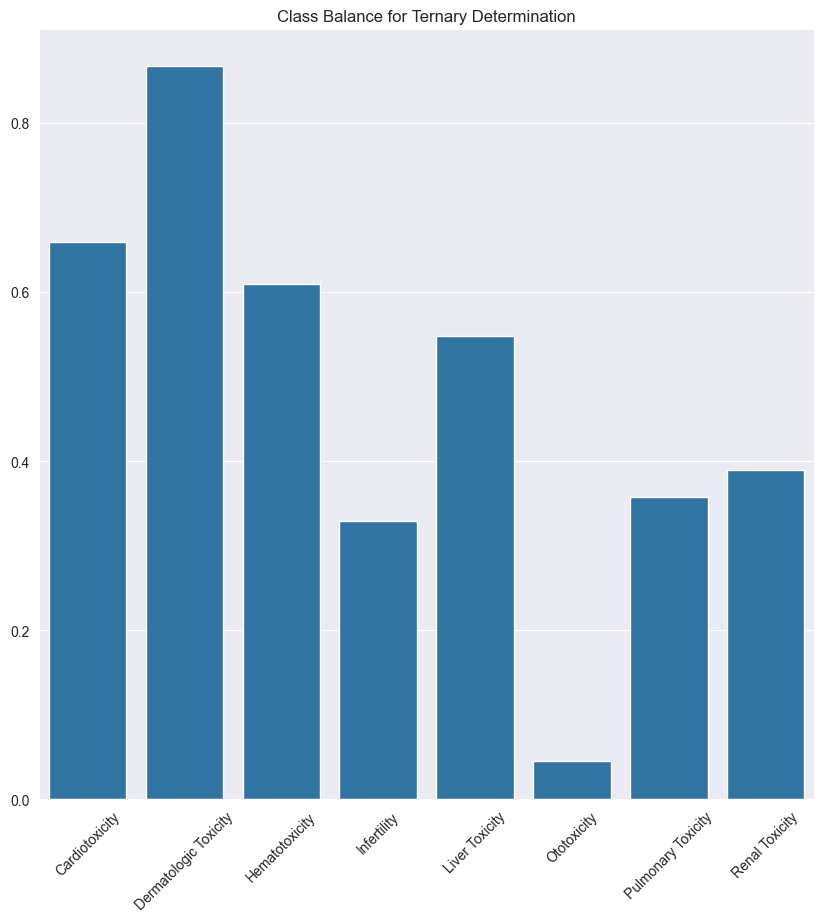

In [117]:
# Plot class balance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

tasks = list(name_to_less_balance.keys())
task_map = {
    "cardio_toxicity": "Cardiotoxicity",
    "dermatologic_toxicity": "Dermatologic Toxicity",
    "hematotoxicity": "Hematotoxicity",
    "infertility": "Infertility",
    "liver_toxicity": "Liver Toxicity",
    "ototoxicity": "Ototoxicity",
    "pulmonary_toxicity": "Pulmonary Toxicity",
    "renal_toxicity": "Renal Toxicity",
}
tasks = [task_map[task] for task in tasks]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=tasks, y=list(name_to_less_balance.values()), ax=ax)
ax.set_title("Class Balance for Confident Ternary Rating")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("/Users/kyleswanson/Downloads/FinaluniTox/figures/class_balance_ternary.pdf", bbox_inches="tight")

/var/folders/mg/1myn4m316m9834glbhfg8_j40000gn/T/ipykernel_14778/3132168610.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


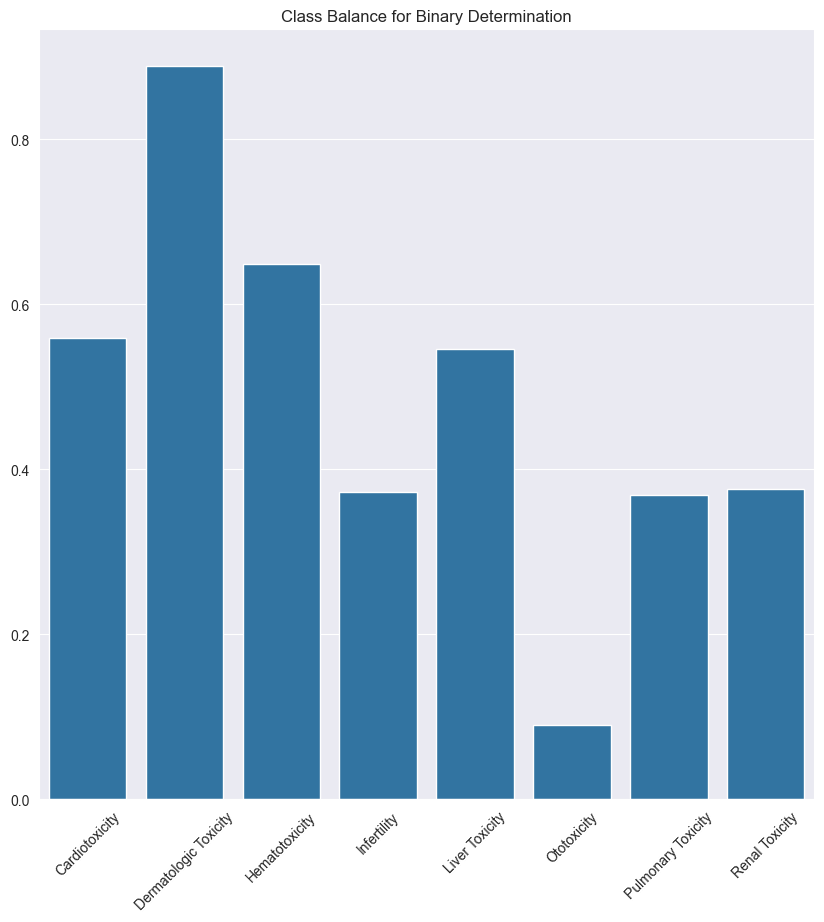

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=tasks, y=list(name_to_binary_balance.values()), ax=ax)
ax.set_title("Class Balance for Binary Rating")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig("/Users/kyleswanson/Downloads/FinaluniTox/figures/class_balance_binary.pdf", bbox_inches="tight")

In [119]:
name_to_less_balance

{'cardio_toxicity': 0.6592674805771365,
 'dermatologic_toxicity': 0.8670157068062827,
 'hematotoxicity': 0.6093023255813953,
 'infertility': 0.32908912830558273,
 'liver_toxicity': 0.5478359908883826,
 'ototoxicity': 0.04564666103127642,
 'pulmonary_toxicity': 0.35807422266800404,
 'renal_toxicity': 0.38924050632911394}

In [120]:
name_to_binary_balance

{'cardio_toxicity': 0.5596738324684952,
 'dermatologic_toxicity': 0.8888065233506302,
 'hematotoxicity': 0.6493699036323203,
 'infertility': 0.37286879169755377,
 'liver_toxicity': 0.5455893254262416,
 'ototoxicity': 0.08969607116382505,
 'pulmonary_toxicity': 0.36916234247590807,
 'renal_toxicity': 0.3765752409191994}